# Working on analysis part of topic modeling

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
import sys
import re, numpy as np, pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Loading file

In [6]:
import pickle

In [9]:
data = pd.read_pickle('top08_topic_dominant.pkl')

In [10]:
data.shape

(68762, 5)

In [11]:
data.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4404,"charge, battery, module, power, electric, syst...","[electrical, energy, system, include, electric..."
1,1,2.0,0.8034,"charge, battery, module, power, electric, syst...","[electrical, energy, system, include, electric..."
2,2,0.0,0.4697,"catalyst, exhaust, gas, parking, fuel, tempera...","[object, provide, particulate, trap, diesel, e..."
3,3,6.0,0.4055,"side, portion, cover, body, housing, part, sur...","[purpose, obtain, trap, leakage, exhaust, gas,..."
4,4,2.0,0.3990,"charge, battery, module, power, electric, syst...","[particulate, trap, diesel, engine, design, ef..."
5,5,0.0,0.4922,"catalyst, exhaust, gas, parking, fuel, tempera...","[pct, pct_jp_sec_date, pub, mar, object, provi..."
6,6,6.0,0.6130,"side, portion, cover, body, housing, part, sur...","[mix, device, gas, fuel, air, internal, combus..."
7,7,6.0,0.5955,"side, portion, cover, body, housing, part, sur...","[mix, device, gas, fuel, air, internal, combus..."
8,8,6.0,0.5115,"side, portion, cover, body, housing, part, sur...","[area, mouth, injector, construct, flow, guide..."
9,9,5.0,0.8511,"air, gas, fuel, exhaust, tank, pipe, pressure,...","[internal, combustion, engine, least, injectio..."


In [12]:
data.Dominant_Topic.value_counts(ascending=True)

0.0     4470
4.0     4699
6.0     7048
5.0     7338
3.0     7860
2.0    10316
7.0    11195
1.0    15836
Name: Dominant_Topic, dtype: int64

above table shows Number of patents applications within specific topic

# Calculating patent share

In [13]:
len(data)

68762

In [14]:
data.Dominant_Topic.value_counts(normalize=True)

1.0    0.230302
7.0    0.162808
2.0    0.150025
3.0    0.114307
5.0    0.106716
6.0    0.102498
4.0    0.068337
0.0    0.065007
Name: Dominant_Topic, dtype: float64

In [15]:
data.Dominant_Topic.mean()

3.4348477356679563

 # 2)-Trends in the number and the share of patents by topics
 
 (a) Change in the number of patents over filing year <br>
 (b) Change in the share of patents over filing year

### 2(a) Change in the number of patents over filing year

In [24]:
import pickle
#Loading from firm cleaned file
patent = pd.read_pickle('patent_firm_full_clean.pkl')
patent.shape

(68764, 35)

**Working with time series and only taking years instead of month and day**

In [25]:
filling_date= patent.earliest_filing_date

In [26]:
patent['application_date']= pd.to_datetime(filling_date)

In [27]:
patent.application_date[:5]

0   1990-07-19
1   1990-07-19
2   1995-02-28
3   1995-02-28
4   1995-02-28
Name: application_date, dtype: datetime64[ns]

we need to only take care of year and not date and month

In [29]:
patent[patent.application_date.dt.year== 2018]

,appln,appln_id,family_id,sets,direct,granted,earliest_appln,earliest_filing_date,publn_date,publn,...,citing_appln,citing_appln_id,citing_family_id,num_citing_family,earliest_applt,current_applt,appln_title,appln_abstr,assignee,application_date
68534,AU2018100117A,490768723,61249370,4,1,1,AU2018100117A,2018-01-26,2018-03-01,AU2018100117A4,...,NaN,NaN,NaN,0,ECODRIVE SOLUTIONS LIMITED,ECODRIVE SOLUTIONS LIMITED,IMPROVED OPPOSED-PISTON INTERNAL COMBUSTION EN...,An improved engine directed to a Low friction ...,ecodrive solutions limited,2018-01-26
68659,KR20180006209A,492385235,61688642,2,1,1,KR20180006209A,2018-01-17,2018-03-07,KR101836061B1,...,NaN,NaN,NaN,0,"KANG, IN SU","KANG, IN SU",AUTONOMOUS ELECTRIC VEHICLE,The present invention relates to an autonomous...,kang in su,2018-01-17


In [30]:
# Remove only two rows with year 2018
patent.drop([68534,68659], axis=0, inplace=True)

In [31]:
patent[patent.application_date.dt.year== 2018]

,appln,appln_id,family_id,sets,direct,granted,earliest_appln,earliest_filing_date,publn_date,publn,...,citing_appln,citing_appln_id,citing_family_id,num_citing_family,earliest_applt,current_applt,appln_title,appln_abstr,assignee,application_date


In [43]:
data['year']=patent['application_date'].dt.year

In [44]:
data.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,year
0,0,2.0,0.4404,"charge, battery, module, power, electric, syst...","[electrical, energy, system, include, electric...",1990.0
1,1,2.0,0.8034,"charge, battery, module, power, electric, syst...","[electrical, energy, system, include, electric...",1990.0
2,2,0.0,0.4697,"catalyst, exhaust, gas, parking, fuel, tempera...","[object, provide, particulate, trap, diesel, e...",1995.0
3,3,6.0,0.4055,"side, portion, cover, body, housing, part, sur...","[purpose, obtain, trap, leakage, exhaust, gas,...",1995.0
4,4,2.0,0.3990,"charge, battery, module, power, electric, syst...","[particulate, trap, diesel, engine, design, ef...",1995.0


In [38]:
type(data)

pandas.core.frame.DataFrame

In [39]:
data.year.value_counts()

2011.0    5737
2012.0    5242
2010.0    4659
2013.0    4247
2009.0    3754
2006.0    3498
2007.0    3444
2014.0    3420
2008.0    3259
2015.0    2686
2005.0    2641
2003.0    2431
2004.0    2310
2001.0    2267
2002.0    2219
2000.0    2211
1999.0    2003
1998.0    1726
1997.0    1581
2016.0    1568
1996.0    1483
1995.0    1285
1993.0    1205
1994.0    1154
1992.0    1008
1991.0     732
1990.0     631
2017.0     359
Name: year, dtype: int64

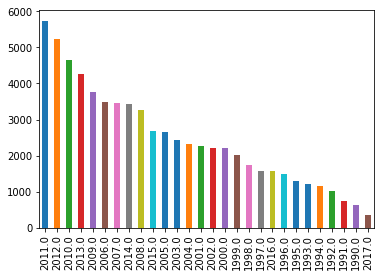

In [40]:
data.year.value_counts().plot(kind='bar')

In [45]:
data['assignee']=patent.assignee

In [46]:
data.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,year,assignee
0,0,2.0,0.4404,"charge, battery, module, power, electric, syst...","[electrical, energy, system, include, electric...",1990.0,luz electric fuel israel ltd
1,1,2.0,0.8034,"charge, battery, module, power, electric, syst...","[electrical, energy, system, include, electric...",1990.0,luz electric fuel israel ltd
2,2,0.0,0.4697,"catalyst, exhaust, gas, parking, fuel, tempera...","[object, provide, particulate, trap, diesel, e...",1995.0,sumitomo electric industries ltd
3,3,6.0,0.4055,"side, portion, cover, body, housing, part, sur...","[purpose, obtain, trap, leakage, exhaust, gas,...",1995.0,sumitomo electric ind ltd
4,4,2.0,0.3990,"charge, battery, module, power, electric, syst...","[particulate, trap, diesel, engine, design, ef...",1995.0,sumitomo electric industries ltd


In [47]:
data.shape

(68762, 7)

In [49]:
data.dtypes

Document_No             int64
Dominant_Topic        float64
Topic_Perc_Contrib    float64
Keywords               object
Text                   object
year                  float64
assignee               object
dtype: object

In [48]:
data.to_pickle('work_on_data.pkl')